In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as progbar
from collections import deque, Counter
import numpy as np
import pandas as pd
from cycler import cycler
from scipy.stats import rankdata
import os

import loc_utils as lut
import vis_utils as vut
from standards import *

rx = RAWXix()
r = RAWix()

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f']

glabels = {0: 'F', 1: 'S'}
clabels = {0: 'i-', 1: 'i+'}

def gclabel(g, c):
    return '{}/{}'.format(glabels[g], clabels[c])

tlabels = {
        1: '1D',
        2: 'I1D',
        3: '2D',
        4: 'R'}

saveloc = '/Users/alexten/Projects/HFSP/img'

# 1. Split subjects by learning and performance
## 1.1. Extract data

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'

train_window_0 = 5
train_window_1 = 7
test_window = 7
test_stage_data = False

save_as = 'pipeline_data/split_data/split_data_v{}-{}-{}_clean.pkl'.format(int(test_stage_data), train_window_1, test_window)

if 1:
    from s3_remove_outliers import remove_by_sid, report_analysis
    
    mdata = lut.unpickle(path)['main']
    lut.report_subject_counts(mdata)

    tasks, groups, sids = lut.get_unique(mdata, *[r.ix(c) for c in ['cat', 'group', 'sid']])
    tasks = tasks[0:-1]
    
    sids_col = []
    groups_col = []
    conds_col = []
    testsize_col = []
    teststart_col = []
    task_col = []
    train_pc_0 = []
    train_pc_1 = []
    test_pc = []
    
    # Locally, check for outliers (those who didn't play at least `test_widnow` times on free play)
    outliers = []
    if test_stage_data:
        g0 = lut.get_mask(mdata, {r.ix('group'): 0})
        sids_g0 = lut.get_unique(mdata[g0,:], r.ix('sid'))
        for sid in progbar(sids_g0, desc='1. Outliers:'):
            for tsk in tasks:
                mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 1, r.ix('cat'): tsk})
                if np.sum(mask) < test_window:
                    outliers.append(sid)
    else:
        for sid in progbar(sids, desc='Outliers:'):
            for tsk in tasks:
                mask = lut.get_mask(mdata, {r.ix('sid'): sid, 
                                            r.ix('stage'): 1, 
                                            r.ix('cat'): tsk})
                if np.sum(mask) < test_window:
                    outliers.append(sid)
                    

    mdata = remove_by_sid(mdata, list(set(outliers)), assign_new_ids=False)
    lut.report_subject_counts(mdata)
    report_analysis('Filtering by min trials during free play', outliers)
    
    sids = lut.get_unique(mdata, r.ix('sid'))
    for sid in progbar(sids, desc='Data'):
        subject_mask = lut.get_mask(mdata, {r.ix('sid'):sid})
        grp = mdata[subject_mask, r.ix('group')][0]
        cnd = mdata[subject_mask, r.ix('cond')][0]
        ii = 1 if test_stage_data*grp else 0
        
        for tsk in tasks:
            # Compute test data
            mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 1 + ii, r.ix('cat'): tsk})
            test = mdata[mask, r.ix('cor')]
            test_pc.append(np.mean(test[-test_window:]))
            testsize_col.append(test.size)
            teststart_col.append(mdata[mask, r.ix('trial')][-test_window])
            
            # Compute train data
            mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 0, r.ix('cat'): tsk})
            train = mdata[mask, r.ix('cor')]
            train_pc_0.append(np.mean(train[:train_window_0]))
            train_pc_1.append(np.mean(train[-train_window_1:]))

            # Record epi data
            groups_col.append(grp)
            conds_col.append(cnd)
            sids_col.append(sid)
            task_col.append(tsk)
            
    
    data = np.stack(
        map(np.array, [groups_col, sids_col, conds_col, task_col, 
                       teststart_col, testsize_col, 
                       train_pc_0, train_pc_1, test_pc]
           )).T
    
    if save_as:
        lut.dopickle(save_as, data)

## 1.2. View learning and performance distributions

<IPython.core.display.Javascript object>


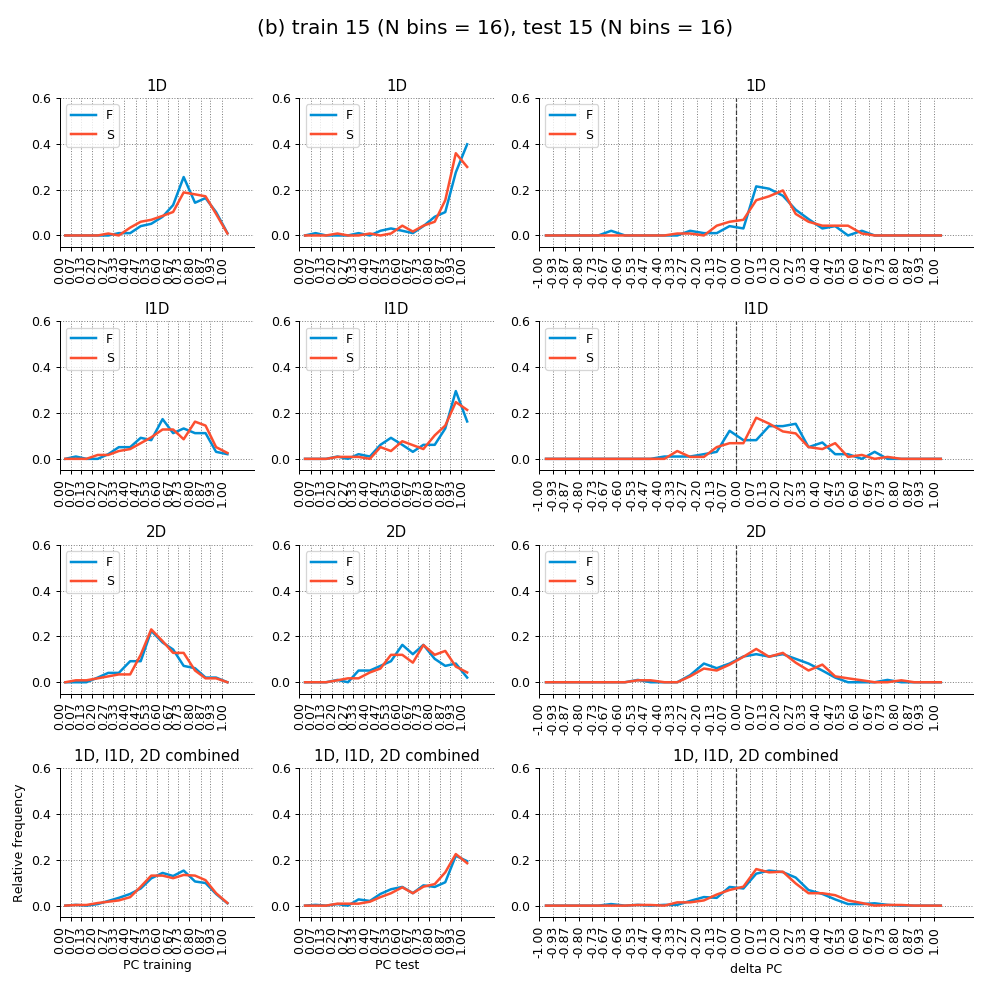

In [10]:
sp = 'b'
v = 0
train_window = 15
test_window = 15
split = 'group'
prec = 2
# saveloc = '/Users/alexten/Desktop'

path = 'pipeline_data/split_data/split_data_v{}-{}-{}_clean.pkl'.format(v, train_window, test_window)
# path = 'pipeline_data/split_data/split_data_v{}-{}-{}_clean.pkl'.format(v, 15, 15)

figname = 'train test delta hists {} {}'.format(train_window, test_window).replace(' ', '_')
save_as = 'svg'

figsize=[11, 11]
rows = 4
cols = 4
plt.rc('axes', prop_cycle=cycler('color', ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']))
plt.rc('lines', linewidth=2)
ylim = .6


if 1:
    ix = ['group', 'sid', 'cond', 'task', 'train_pc', 'test_pc'].index
    data = lut.unpickle(path)[:, [0, 1, 2, 3, 7, 8]]
    
    groups, tasks = [lut.get_unique(data, ix(col)) for col in [split, 'task']]
    
    fig = plt.figure(num=figname.split('/')[-1].replace('_', ' '), figsize=figsize)
    gs = mpl.gridspec.GridSpec(tasks.size + 1, 4)
    
    for ti, tsk in enumerate(tasks):
        g0 = lut.get_mask(data, {ix(split): 0, ix('task'): tsk})
        g1 = lut.get_mask(data, {ix(split): 1, ix('task'): tsk})
        
        train_pc = [data[g0, ix('train_pc')], data[g1, ix('train_pc')]]
        test_pc = [data[g0, ix('test_pc')], data[g1, ix('test_pc')]]
        delta_pc = [b - a for a, b in zip(train_pc, test_pc)]
        
        lax = fig.add_subplot(gs[ti, 0])
        midax = fig.add_subplot(gs[ti, 1])
        rax = fig.add_subplot(gs[ti, 2:])
        
        lax.set_xlim(0,1.2)
        lax.set_ylim(-.05, ylim)
        
        midax.set_xlim(0,1.2)
        midax.set_ylim(-.05, ylim)
        
        rax.set_xlim(-1., 1.2)
        rax.set_ylim(-.05, ylim)
        
        rax.axvline(0, c='k', alpha=.7, ls='--', lw=1)
        for i, (pc0, pc1, dpc) in enumerate(zip(train_pc, test_pc, delta_pc)):
            b0 = np.arange(0, 1.01 + 1/train_window, 1/train_window, dtype=pc0.dtype)
            b1 = np.arange(0, 1.01 + 1/test_window, 1/test_window, dtype=pc1.dtype)
            b2 = np.array(
                np.array([-i for i in reversed(b0[1:-1].tolist())]+b0.tolist(), dtype=dpc.dtype)
            )
            vut.line_histogram(lax, pc0, b0, glabels[i], prec, lw=2)
            vut.line_histogram(midax, pc1, b1, glabels[i], prec, lw=2)
            vut.line_histogram(rax, dpc, b2, glabels[i], prec, lw=2)
        
        for ax, b in zip([lax, midax, rax], [b0, b1, b2]):
            
            ax.legend(loc=2)
            ax.set_title(tlabels[tsk])
            ax.set_xticklabels(np.around(b,2), rotation=90)
            ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

    
    # ==================== bottom row =======================
    lax = fig.add_subplot(gs[3, 0])
    midax = fig.add_subplot(gs[3, 1])
    rax = fig.add_subplot(gs[3, 2:])

    lax.set_xlim(0,1.2)
    lax.set_ylim(-.05, ylim)

    midax.set_xlim(0,1.2)
    midax.set_ylim(-.05, ylim)

    rax.set_xlim(-1., 1.2)
    rax.set_ylim(-.05, ylim)

    rax.axvline(0, c='k', alpha=.7, ls='--', lw=1)
    
    for ax, b in zip([lax, midax, rax], [b0, b1, b2]):
        ax.set_title('1D, I1D, 2D combined')
        ax.set_xticklabels(np.around(b,2), rotation=90)
        ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))


        lax.set_ylabel('Relative frequency')
        lax.set_xlabel('PC training')
        midax.set_xlabel('PC test')
        rax.set_xlabel('delta PC')
        
    for grp in groups:
        gmask = lut.get_mask(data, {ix(split): grp})
        train_pc = data[gmask, ix('train_pc')]
        test_pc = data[gmask, ix('test_pc')]
        delta_pc = test_pc - train_pc

        vut.line_histogram(lax, train_pc, b0, glabels[grp], prec, lw=2)
        vut.line_histogram(midax, test_pc, b1, glabels[grp], prec, lw=2)
        vut.line_histogram(rax, delta_pc, b2, glabels[grp], prec, lw=2)
    # ==================== bottom row =======================    
        
    fig.tight_layout()   
    fig.subplots_adjust(hspace=.5, top=.9)
    # train_window = 15
    # test_window = 15
    fig.suptitle(
        '({}) train {} (N bins = {}), test {} (N bins = {})'.format(sp, 
                                                       train_window, b0.size-1,
                                                       test_window, b1.size-1), 
        fontsize=16)
    
    if save_as:
        s = saveloc+'/{}_{}.{}'.format(figname, sp, save_as)
        fig.savefig(s, format=save_as, dpi=500)
        os.system('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))

In [ ]:
def make_bins(start, step, N):
    return [start + (step * i) for i in range(N + 2)]

n=10
make_bins(0, 1/n, n)[7]

In [ ]:
np.sum([0,0,0,1,1,1,1,1,1,1], dtype=np.float32)/10